### Aim : Implement the concept of regularization, gradient checking, optimization in CNN

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable

In [10]:
# Set device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [11]:
# Example: define transform for dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1000)


Step 2: Visualize the dataset

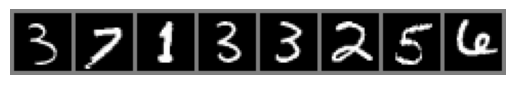

Labels: [3, 4, 1, 3, 3, 2, 5, 6]


In [15]:
def imshow(img):
    img = img * 0.5 + 0.5  # unnormalize: from [-1,1] to [0,1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap="gray")
    plt.axis('off')
    plt.show()

# Get one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show the first 8 images
imshow(torchvision.utils.make_grid(images[:8], nrow=8))
print("Labels:", labels[:8].tolist())

Designed a CNN to classify handwritten digits from the MNIST dataset. It takes a 28×28 grayscale image as input, passes it through two convolutional layers with ReLU activations and max pooling to extract spatial features, then flattens the output into a vector of size 512. This is followed by two fully connected layers: one hidden layer with 128 neurons and an output layer with 10 neurons (representing digit classes 0–9). An optional dropout layer can be applied to reduce overfitting by randomly deactivating 50% of neurons during training. The final output is a set of scores (logits) used to predict the digit class.

Step 3: Define CNN

In [16]:
class CNN(nn.Module):
    def __init__(self, dropout=False):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        self.dropout = dropout
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, 10)
        self.drop = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 512)
        x = F.relu(self.fc1(x))
        if self.dropout:
            x = self.drop(x)
        return self.fc2(x)

train_model function trains a CNN on batches of data for a given number of epochs using an optimizer like SGD or Adam. It performs forward and backward passes for each batch, computes the cross-entropy loss, applies optional L2 regularization, updates weights, and tracks average loss per epoch. The final output is a list of training losses, which helps monitor how well the model is learning over time.

Step 3: Use Train function

In [17]:
# 3. Training Function
def train_model(model, optimizer, epochs=5, l2_lambda=0):
    model.train()
    train_losses = []

    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)

            # L2 Regularization
            l2_reg = sum(torch.norm(param) for param in model.parameters())
            loss += l2_lambda * l2_reg

            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}")

    return train_losses

Step 4: Training Model with and Without Dropout Layer

In [18]:
# 4. Model Training: With and Without Dropout
model1 = CNN(dropout=False).to(device)
model2 = CNN(dropout=True).to(device)

optimizer1 = torch.optim.SGD(model1.parameters(), lr=0.01)
optimizer2 = torch.optim.SGD(model2.parameters(), lr=0.01)

print("\nTraining without Dropout...")
losses1 = train_model(model1, optimizer1, l2_lambda=1e-4)


Training without Dropout...
Epoch 1: Loss = 1.0561
Epoch 2: Loss = 0.1844
Epoch 3: Loss = 0.1205
Epoch 4: Loss = 0.0945
Epoch 5: Loss = 0.0800


In [19]:
print("\nTraining with Dropout...")
losses2 = train_model(model2, optimizer2, l2_lambda=1e-4)


Training with Dropout...
Epoch 1: Loss = 1.1476
Epoch 2: Loss = 0.2770
Epoch 3: Loss = 0.1879
Epoch 4: Loss = 0.1505
Epoch 5: Loss = 0.1283


Output:

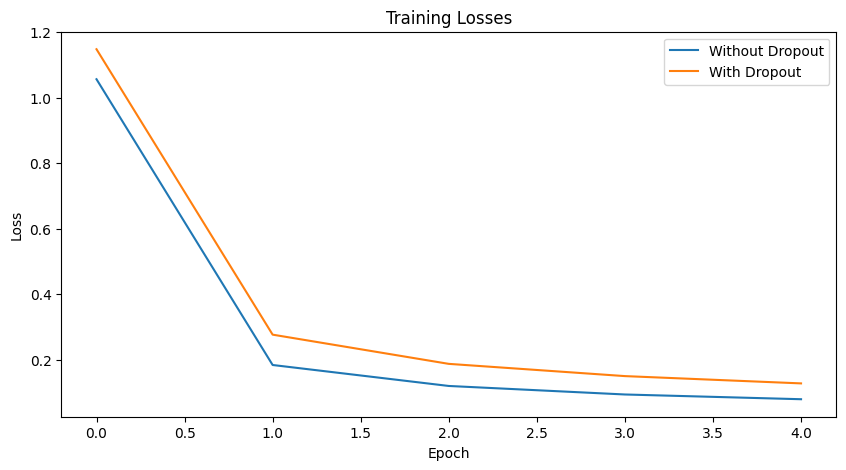

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(losses1, label="Without Dropout")
plt.plot(losses2, label="With Dropout")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Losses")
plt.legend()
plt.show()

Gradient checking is a technique to verify that the gradients computed by backpropagation are correct. It does this by comparing them with manually approximated gradients using a small perturbation (finite difference method). In the provided code, two specific parameters of the first convolutional layer are checked. For each one, the loss is recalculated after slightly increasing and decreasing the parameter value, and the gradient is estimated from the difference. This is then compared with the gradient calculated by PyTorch's automatic differentiation. If they match, it means the gradient computation is likely correct.

Step 5: Gradient checking


Gradient Checking on First Conv Layer [0, 0, 0, 0] and [0, 0, 0, 1]:
Param(0, 0, 0, 0): Grad approx = 0.017881, Backprop grad = 0.016852
Param(0, 0, 0, 1): Grad approx = 0.028610, Backprop grad = 0.028941


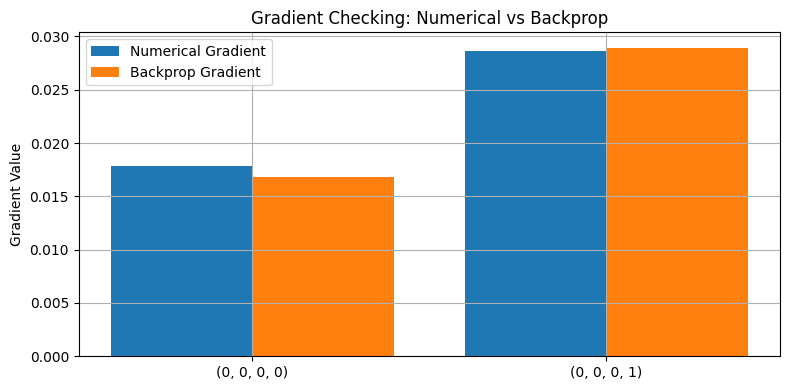

In [33]:
def visualize_gradients(grad_approx_vals, grad_backprop_vals, labels):
    x = range(len(labels))
    plt.figure(figsize=(8, 4))
    plt.bar(x, grad_approx_vals, width=0.4, label="Numerical Gradient", align='center')
    plt.bar([i + 0.4 for i in x], grad_backprop_vals, width=0.4, label="Backprop Gradient", align='center')
    plt.xticks([i + 0.2 for i in x], labels)
    plt.ylabel("Gradient Value")
    plt.title("Gradient Checking: Numerical vs Backprop")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def gradient_checking():
    model = CNN().to("cpu")
    model.eval()

    x = torch.randn(1, 1, 28, 28, requires_grad=True)
    y = torch.tensor([3])

    output = model(x)
    loss = F.cross_entropy(output, y)
    loss.backward()

    epsilon = 1e-4
    param = list(model.parameters())[0]

    print("\nGradient Checking on First Conv Layer [0, 0, 0, 0] and [0, 0, 0, 1]:")

    grad_approx_vals = []
    grad_backprop_vals = []
    labels = []

    for idx in [(0, 0, 0, 0), (0, 0, 0, 1)]:
        original = param.data[idx].item()

        param.data[idx] = original + epsilon
        output1 = model(x)
        loss1 = F.cross_entropy(output1, y)

        param.data[idx] = original - epsilon
        output2 = model(x)
        loss2 = F.cross_entropy(output2, y)

        grad_approx_val = (loss1 - loss2) / (2 * epsilon)
        param.data[idx] = original  # restore

        grad_backprop_val = param.grad[idx].item()

        grad_approx_vals.append(grad_approx_val.item())
        grad_backprop_vals.append(grad_backprop_val)
        labels.append(str(idx))

        print(f"Param{idx}: Grad approx = {grad_approx_val:.6f}, Backprop grad = {grad_backprop_val:.6f}")

    visualize_gradients(grad_approx_vals, grad_backprop_vals, labels)


gradient_checking()

Step 6: Creating two instances of the CNN

In [34]:
model_sgd = CNN().to(device)
model_adam = CNN().to(device)

opt_sgd = torch.optim.SGD(model_sgd.parameters(), lr=0.01)
opt_adam = torch.optim.Adam(model_adam.parameters(), lr=0.001)

print("\nTraining with SGD...")
loss_sgd = train_model(model_sgd, opt_sgd)


Training with SGD...
Epoch 1: Loss = 0.9411
Epoch 2: Loss = 0.1710
Epoch 3: Loss = 0.1137
Epoch 4: Loss = 0.0905
Epoch 5: Loss = 0.0771


Step 12: Training with Adam


Training with Adam...
Epoch 1: Loss = 0.1868
Epoch 2: Loss = 0.0500
Epoch 3: Loss = 0.0348
Epoch 4: Loss = 0.0268
Epoch 5: Loss = 0.0215


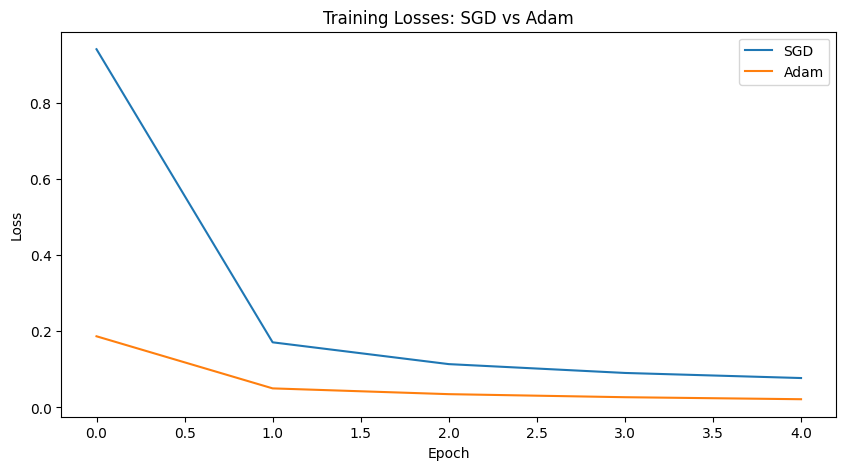

In [35]:
print("\nTraining with Adam...")
loss_adam = train_model(model_adam, opt_adam)

# 8. visulization optimizer comparison
plt.figure(figsize=(10, 5))
plt.plot(loss_sgd, label="SGD")
plt.plot(loss_adam, label="Adam")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Losses: SGD vs Adam")
plt.legend()
plt.show()